# Lane Detection Project - by Magomedov Rustam; fall 2022 cohort

** `pls note that i didn't add the dataset to the repo (since it weighs 20gb+)`


In this project you need to construct computer vision solution for a lane detection. We are going to implement [LaneNet](https://arxiv.org/pdf/1802.05591.pdf) paper. Our solution is going to have the following parts:

1. Lane semantic segmentation and metric learning
2. Instance segmentation over embedings
3. Homography prediction
4. Lane fitting

We are going to use [TuSimple](https://github.com/TuSimple/tusimple-benchmark/issues/3) dataset for a lane detection.

Let's discuss every step in details.

## Semantic and Instance Segmentation

In this part you should implement and train neural network with the 2 heads. The model should take as an input image and returns to masks. One head should predict *semantic segmentation* and another head should predict *embedding for each pixel*. Pixels that are part of one lane should have similar embeddings, on the other hand pixels from different lanes should have high distance between embeddings. In order to do that, we should implement *discriminative loss*.

After training the discribed network, we can threshold pixels of the interest and cluster them according to the embedding with the *DBSCAN*.

After solving the problem you should obtain the following result.

## Homograpy Prediction

In order to solve the problem, we would like to understand an exact lane geometry. We are going to describe the lane with the 2-nd order polynom $ax^2 + bx + c$.

In the image plane lines are not parallel and we may need higher order polynoms to discribe the lane geometry. In order to avoid that we could project image in the bird's eye view with the homography. But drivable surface has different properties over frames, so we would like to condition the homography on the image.

In order to do that, we going to train separate network to predict the best homography for each image.

## Lane Fitting

After predicting homography and lane's clustering we will fit 2-nd order polynom for each lane to obtain the final result. Lane fitting can be formulated as a least-squares problem, where we have points $\{x_i, y_i\}_{i=1}^n$ and we would like to estimation coefficients $a, b, c$ s.t.

$$
\sum_{i = 1}^n ||y_i - a x_i^2 - bx_i - c||^2 \rightarrow \min_{a, b,c}
$$



## Important Notes
0. During the project we provide the relevant papers. Reading the papers can be very helpful (and sometimes necessary) to implement the code.
1. During the project we provide you with the code templates that you should fill.
2. Homography Prediction and Instance Segmentation can be done in parallel.
3. You are free to use any other environment instead of Google Colab.
4. You can deviate from the original papers if it helps you to solve the problem, but you should explain your solution and motivation in the text block.

## Semantic and Segmentation Code

You can use the following commands to download the dataset and unpack it. But we suggest to upload the data to the Google Drive, with Google Drive you will be able to access the data much faster.

In the following cell you should implement pytorch Dataset to generate training examples for instance and semantic segmentation. You are able to modify the signatures if you want.

To implement the LaneDataset you should become familiar with the labeling format.

The dataset is relatively small, so it is important to implement different augmentation strategies. We suggest to use random flips and color augmentations (brightness, saturation). You can also use augmentations of your choice. Augmentations are not required to obtain a full grade but without them your model could overfit dramatically.

NOTE: It can be useful to generate binary segmentation and instance segmentation ground truth once and then use it as-is in every experiment.

In [1]:
# libs & functions
from modules.DependentLibraries import *
import modules.SupportFuncs as sf

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Let's load the labels and the images. Given that 0531 contains least labels, we can use it for validation.

In [3]:
labels = []
path = 'TUSimple/train_set/label_data'
nums = ['0313', '0531', '0601']

for num in nums:
    labels = sf.load_labels(os.path.join(f'{path}_{num}.json'), labels)
    print(f'Loaded {num} dir, {len(labels)} total labels')

Loaded 0313 dir, 2858 total labels
Loaded 0531 dir, 3216 total labels
Loaded 0601 dir, 3626 total labels


For this task we are going to use ENet architecture. You can read the description in the [original paper](https://arxiv.org/pdf/1606.02147.pdf).

To generate two different outputs we need to have two different branches. In the LaneNet paper authers proposed to share only two first sections of the encoder between to tasks. Third section and decoder should be separate for the instance segmentation and binary segmentation problem.

The output dimension of the instance segmentation embedding should be equal to 5.

In [4]:
from modules.datasets.LaneDataset import LaneDataset

To obtain the instance segmentation we should train the embeddings as we described in the project description. In order to do that we need to implement [Discriminative Loss](https://arxiv.org/pdf/1708.02551.pdf). Discriminative loss consists of three parts:

1. Inter-cluster push-force: cluster means should be far away from each other
2. Intra-cluster pull-force: embeddings should be close to the center of the corresponding cluster.
3. Regularization: cluster centers should be close to zero.

Corresponding weights for the losses and other hyper-parameters could be found in the paper.

In [5]:
from modules.bottlenecks import *
from modules.models.ENetModel import ENet

Now we are ready to train the network. You may want to create validation subset to track metrics.

In [6]:
BATCH_SIZE = 16
transforms = v2.Compose([v2.RandomHorizontalFlip(),
                         v2.ColorJitter(brightness=.45, hue=.33)])

tr_dataset = LaneDataset(dataset_path='TUSimple/train_set/', train=True, transform=transforms)
tr_dataloader = torch.utils.data.DataLoader(tr_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = LaneDataset(dataset_path='TUSimple/train_set/', train=False, transform=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

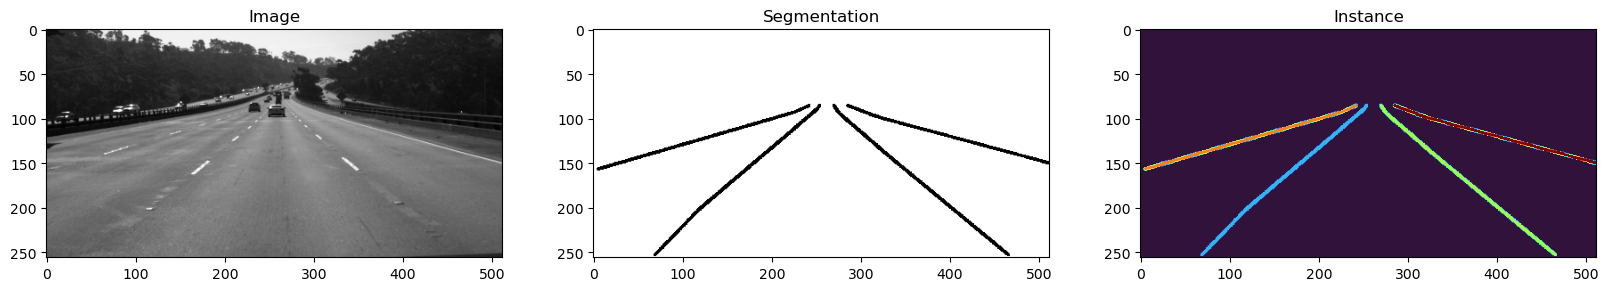

In [7]:
# get random item from dataloader and visualize the image, 
# binary and instance labels
sf.visualize_lane_dataset(tr_dataloader)

In [8]:
# hyperparameters for ENet training
LR = 3e-4
DECAY = 2e-4
NUM_EPOCHS = 50

# init ENet model
enet_model = ENet(2, 5).to(device)

# set optimizer
params = [p for p in enet_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=LR, weight_decay=DECAY)

In [10]:
sf.train_enet(enet_model, tr_dataloader, val_dataloader, optimizer, device, epochs=50)
torch.save(enet_model.state_dict(), f'enet_{NUM_EPOCHS}_epochs_5d.pth')  # for training/retraining purposes

Epoch 1:


100%|██████████| 23/23 [00:07<00:00,  3.22it/s]


Binary Loss train = 0.3324, Instance Loss train = 4.6400, Binary Accuracy train = 0.8972
Binary Loss val = 0.1217, Instance Loss val = 2.5368, Binary Accuracy val = 0.9752


Epoch 2:


100%|██████████| 23/23 [00:07<00:00,  3.26it/s]


Binary Loss train = 0.1022, Instance Loss train = 1.1654, Binary Accuracy train = 0.9718
Binary Loss val = 0.0763, Instance Loss val = 1.8574, Binary Accuracy val = 0.9757


Epoch 3:


100%|██████████| 23/23 [00:07<00:00,  3.27it/s]


Binary Loss train = 0.0730, Instance Loss train = 0.6486, Binary Accuracy train = 0.9727
Binary Loss val = 0.0661, Instance Loss val = 1.6166, Binary Accuracy val = 0.9765


Epoch 4:


100%|██████████| 23/23 [00:07<00:00,  3.17it/s]


Binary Loss train = 0.0629, Instance Loss train = 0.5006, Binary Accuracy train = 0.9737
Binary Loss val = 0.0573, Instance Loss val = 1.5652, Binary Accuracy val = 0.9774


Epoch 5:


100%|██████████| 23/23 [00:07<00:00,  3.17it/s]


Binary Loss train = 0.0571, Instance Loss train = 0.4026, Binary Accuracy train = 0.9754
Binary Loss val = 0.0557, Instance Loss val = 1.4983, Binary Accuracy val = 0.9784


Epoch 6:


100%|██████████| 23/23 [00:07<00:00,  3.18it/s]


Binary Loss train = 0.0533, Instance Loss train = 0.3254, Binary Accuracy train = 0.9773
Binary Loss val = 0.0537, Instance Loss val = 1.4782, Binary Accuracy val = 0.9799


Epoch 7:


100%|██████████| 23/23 [00:07<00:00,  3.20it/s]


Binary Loss train = 0.0516, Instance Loss train = 0.3393, Binary Accuracy train = 0.9784
Binary Loss val = 0.0513, Instance Loss val = 1.4585, Binary Accuracy val = 0.9808


Epoch 8:


100%|██████████| 23/23 [00:07<00:00,  3.18it/s]


Binary Loss train = 0.0497, Instance Loss train = 0.2883, Binary Accuracy train = 0.9792
Binary Loss val = 0.0523, Instance Loss val = 1.6944, Binary Accuracy val = 0.9806


Epoch 9:


100%|██████████| 23/23 [00:07<00:00,  3.19it/s]


Binary Loss train = 0.0477, Instance Loss train = 0.2456, Binary Accuracy train = 0.9799
Binary Loss val = 0.0499, Instance Loss val = 1.4934, Binary Accuracy val = 0.9808


Epoch 10:


100%|██████████| 23/23 [00:07<00:00,  3.18it/s]


Binary Loss train = 0.0468, Instance Loss train = 0.2356, Binary Accuracy train = 0.9802
Binary Loss val = 0.0483, Instance Loss val = 1.4748, Binary Accuracy val = 0.9815


Epoch 11:


100%|██████████| 23/23 [00:07<00:00,  3.19it/s]


Binary Loss train = 0.0456, Instance Loss train = 0.2038, Binary Accuracy train = 0.9805
Binary Loss val = 0.0484, Instance Loss val = 1.3873, Binary Accuracy val = 0.9818


Epoch 12:


100%|██████████| 23/23 [00:07<00:00,  3.18it/s]


Binary Loss train = 0.0451, Instance Loss train = 0.1945, Binary Accuracy train = 0.9807
Binary Loss val = 0.0487, Instance Loss val = 1.4007, Binary Accuracy val = 0.9807


Epoch 13:


100%|██████████| 23/23 [00:07<00:00,  3.14it/s]


Binary Loss train = 0.0444, Instance Loss train = 0.1925, Binary Accuracy train = 0.9809
Binary Loss val = 0.0467, Instance Loss val = 1.2446, Binary Accuracy val = 0.9820


Epoch 14:


100%|██████████| 23/23 [00:07<00:00,  3.19it/s]


Binary Loss train = 0.0438, Instance Loss train = 0.1860, Binary Accuracy train = 0.9811
Binary Loss val = 0.0461, Instance Loss val = 1.2798, Binary Accuracy val = 0.9818


Epoch 15:


100%|██████████| 23/23 [00:07<00:00,  3.13it/s]


Binary Loss train = 0.0433, Instance Loss train = 0.1649, Binary Accuracy train = 0.9813
Binary Loss val = 0.0449, Instance Loss val = 1.2718, Binary Accuracy val = 0.9824


Epoch 16:


100%|██████████| 23/23 [00:07<00:00,  3.17it/s]


Binary Loss train = 0.0429, Instance Loss train = 0.1534, Binary Accuracy train = 0.9814
Binary Loss val = 0.0466, Instance Loss val = 1.1843, Binary Accuracy val = 0.9823


Epoch 17:


100%|██████████| 23/23 [00:07<00:00,  3.18it/s]


Binary Loss train = 0.0427, Instance Loss train = 0.1525, Binary Accuracy train = 0.9815
Binary Loss val = 0.0482, Instance Loss val = 1.2397, Binary Accuracy val = 0.9823


Epoch 18:


100%|██████████| 23/23 [00:07<00:00,  3.18it/s]


Binary Loss train = 0.0427, Instance Loss train = 0.1651, Binary Accuracy train = 0.9815
Binary Loss val = 0.0517, Instance Loss val = 1.5184, Binary Accuracy val = 0.9819


Epoch 19:


100%|██████████| 23/23 [00:07<00:00,  3.17it/s]


Binary Loss train = 0.0428, Instance Loss train = 0.1800, Binary Accuracy train = 0.9816
Binary Loss val = 0.0465, Instance Loss val = 1.1542, Binary Accuracy val = 0.9823


Epoch 20:


100%|██████████| 23/23 [00:07<00:00,  3.19it/s]


Binary Loss train = 0.0420, Instance Loss train = 0.1239, Binary Accuracy train = 0.9818
Binary Loss val = 0.0459, Instance Loss val = 1.2315, Binary Accuracy val = 0.9825


Epoch 21:


100%|██████████| 23/23 [00:07<00:00,  3.18it/s]


Binary Loss train = 0.0418, Instance Loss train = 0.1163, Binary Accuracy train = 0.9818
Binary Loss val = 0.0456, Instance Loss val = 1.0149, Binary Accuracy val = 0.9825


Epoch 22:


100%|██████████| 23/23 [00:07<00:00,  3.17it/s]


Binary Loss train = 0.0414, Instance Loss train = 0.1059, Binary Accuracy train = 0.9820
Binary Loss val = 0.0461, Instance Loss val = 1.1176, Binary Accuracy val = 0.9823


Epoch 23:


100%|██████████| 23/23 [00:07<00:00,  3.17it/s]


Binary Loss train = 0.0413, Instance Loss train = 0.0997, Binary Accuracy train = 0.9821
Binary Loss val = 0.0473, Instance Loss val = 1.1413, Binary Accuracy val = 0.9828


Epoch 24:


100%|██████████| 23/23 [00:07<00:00,  3.16it/s]


Binary Loss train = 0.0415, Instance Loss train = 0.0946, Binary Accuracy train = 0.9820
Binary Loss val = 0.0473, Instance Loss val = 1.0108, Binary Accuracy val = 0.9826


Epoch 25:


100%|██████████| 23/23 [00:07<00:00,  3.16it/s]


Binary Loss train = 0.0410, Instance Loss train = 0.0900, Binary Accuracy train = 0.9822
Binary Loss val = 0.0488, Instance Loss val = 0.8163, Binary Accuracy val = 0.9811


Epoch 26:


100%|██████████| 23/23 [00:07<00:00,  3.17it/s]


Binary Loss train = 0.0409, Instance Loss train = 0.0873, Binary Accuracy train = 0.9822
Binary Loss val = 0.0457, Instance Loss val = 0.8245, Binary Accuracy val = 0.9822


Epoch 27:


100%|██████████| 23/23 [00:07<00:00,  3.18it/s]


Binary Loss train = 0.0411, Instance Loss train = 0.0926, Binary Accuracy train = 0.9822
Binary Loss val = 0.0484, Instance Loss val = 0.9893, Binary Accuracy val = 0.9822


Epoch 28:


100%|██████████| 23/23 [00:07<00:00,  3.17it/s]


Binary Loss train = 0.0424, Instance Loss train = 0.1259, Binary Accuracy train = 0.9818
Binary Loss val = 0.0455, Instance Loss val = 0.3832, Binary Accuracy val = 0.9825


Epoch 29:


100%|██████████| 23/23 [00:07<00:00,  3.19it/s]


Binary Loss train = 0.0412, Instance Loss train = 0.0632, Binary Accuracy train = 0.9822
Binary Loss val = 0.0445, Instance Loss val = 0.3322, Binary Accuracy val = 0.9823


Epoch 30:


100%|██████████| 23/23 [00:07<00:00,  3.18it/s]


Binary Loss train = 0.0402, Instance Loss train = 0.0483, Binary Accuracy train = 0.9825
Binary Loss val = 0.0456, Instance Loss val = 0.3663, Binary Accuracy val = 0.9827


Epoch 31:


100%|██████████| 23/23 [00:07<00:00,  3.19it/s]


Binary Loss train = 0.0398, Instance Loss train = 0.0457, Binary Accuracy train = 0.9827
Binary Loss val = 0.0439, Instance Loss val = 0.3516, Binary Accuracy val = 0.9831


Epoch 32:


100%|██████████| 23/23 [00:07<00:00,  3.18it/s]


Binary Loss train = 0.0395, Instance Loss train = 0.0410, Binary Accuracy train = 0.9828
Binary Loss val = 0.0437, Instance Loss val = 0.3247, Binary Accuracy val = 0.9830


Epoch 33:


100%|██████████| 23/23 [00:07<00:00,  3.17it/s]


Binary Loss train = 0.0391, Instance Loss train = 0.0386, Binary Accuracy train = 0.9830
Binary Loss val = 0.0453, Instance Loss val = 0.3617, Binary Accuracy val = 0.9823


Epoch 34:


100%|██████████| 23/23 [00:07<00:00,  3.20it/s]


Binary Loss train = 0.0386, Instance Loss train = 0.0365, Binary Accuracy train = 0.9832
Binary Loss val = 0.0454, Instance Loss val = 0.3486, Binary Accuracy val = 0.9821


Epoch 35:


100%|██████████| 23/23 [00:07<00:00,  3.18it/s]


Binary Loss train = 0.0387, Instance Loss train = 0.0372, Binary Accuracy train = 0.9831
Binary Loss val = 0.0439, Instance Loss val = 0.3627, Binary Accuracy val = 0.9827


Epoch 36:


100%|██████████| 23/23 [00:07<00:00,  3.13it/s]


Binary Loss train = 0.0383, Instance Loss train = 0.0347, Binary Accuracy train = 0.9833
Binary Loss val = 0.0452, Instance Loss val = 0.3241, Binary Accuracy val = 0.9832


Epoch 37:


100%|██████████| 23/23 [00:07<00:00,  3.19it/s]


Binary Loss train = 0.0383, Instance Loss train = 0.0340, Binary Accuracy train = 0.9833
Binary Loss val = 0.0454, Instance Loss val = 0.3487, Binary Accuracy val = 0.9826


Epoch 38:


100%|██████████| 23/23 [00:07<00:00,  3.18it/s]


Binary Loss train = 0.0379, Instance Loss train = 0.0314, Binary Accuracy train = 0.9835
Binary Loss val = 0.0433, Instance Loss val = 0.3496, Binary Accuracy val = 0.9830


Epoch 39:


100%|██████████| 23/23 [00:07<00:00,  3.18it/s]


Binary Loss train = 0.0378, Instance Loss train = 0.0322, Binary Accuracy train = 0.9835
Binary Loss val = 0.0452, Instance Loss val = 0.3319, Binary Accuracy val = 0.9831


Epoch 40:


100%|██████████| 23/23 [00:07<00:00,  3.14it/s]


Binary Loss train = 0.0376, Instance Loss train = 0.0317, Binary Accuracy train = 0.9836
Binary Loss val = 0.0455, Instance Loss val = 0.3432, Binary Accuracy val = 0.9827


Epoch 41:


100%|██████████| 23/23 [00:07<00:00,  3.19it/s]


Binary Loss train = 0.0378, Instance Loss train = 0.0334, Binary Accuracy train = 0.9835
Binary Loss val = 0.0439, Instance Loss val = 0.3266, Binary Accuracy val = 0.9829


Epoch 42:


100%|██████████| 23/23 [00:07<00:00,  3.18it/s]


Binary Loss train = 0.0374, Instance Loss train = 0.0292, Binary Accuracy train = 0.9837
Binary Loss val = 0.0445, Instance Loss val = 0.3165, Binary Accuracy val = 0.9828


Epoch 43:


100%|██████████| 23/23 [00:07<00:00,  3.18it/s]


Binary Loss train = 0.0372, Instance Loss train = 0.0264, Binary Accuracy train = 0.9837
Binary Loss val = 0.0444, Instance Loss val = 0.3720, Binary Accuracy val = 0.9833


Epoch 44:


100%|██████████| 23/23 [00:07<00:00,  3.18it/s]


Binary Loss train = 0.0371, Instance Loss train = 0.0283, Binary Accuracy train = 0.9837
Binary Loss val = 0.0458, Instance Loss val = 0.3319, Binary Accuracy val = 0.9825


Epoch 45:


100%|██████████| 23/23 [00:07<00:00,  3.18it/s]


Binary Loss train = 0.0367, Instance Loss train = 0.0274, Binary Accuracy train = 0.9839
Binary Loss val = 0.0450, Instance Loss val = 0.3047, Binary Accuracy val = 0.9822


Epoch 46:


100%|██████████| 23/23 [00:07<00:00,  3.17it/s]


Binary Loss train = 0.0367, Instance Loss train = 0.0261, Binary Accuracy train = 0.9840
Binary Loss val = 0.0455, Instance Loss val = 0.3435, Binary Accuracy val = 0.9828


Epoch 47:


100%|██████████| 23/23 [00:07<00:00,  3.18it/s]


Binary Loss train = 0.0366, Instance Loss train = 0.0252, Binary Accuracy train = 0.9840
Binary Loss val = 0.0439, Instance Loss val = 0.3112, Binary Accuracy val = 0.9833


Epoch 48:


100%|██████████| 23/23 [00:07<00:00,  3.18it/s]


Binary Loss train = 0.0362, Instance Loss train = 0.0245, Binary Accuracy train = 0.9841
Binary Loss val = 0.0448, Instance Loss val = 0.2949, Binary Accuracy val = 0.9833


Epoch 49:


100%|██████████| 23/23 [00:07<00:00,  3.19it/s]


Binary Loss train = 0.0366, Instance Loss train = 0.0260, Binary Accuracy train = 0.9839
Binary Loss val = 0.0464, Instance Loss val = 0.3150, Binary Accuracy val = 0.9826


Epoch 50:


100%|██████████| 23/23 [00:07<00:00,  3.19it/s]

Binary Loss train = 0.0362, Instance Loss train = 0.0254, Binary Accuracy train = 0.9841
Binary Loss val = 0.0455, Instance Loss val = 0.3254, Binary Accuracy val = 0.9828




In [13]:
%load_ext tensorboard

In [18]:
# torch.save(enet_model.state_dict(), f'enet_{NUM_EPOCHS}_epochs_)  # for training/retraining purposes

In [9]:
# load the trained model from disk
enet_model.load_state_dict(torch.load('trained-models/enet_50_epochs_5d.pth'))

<All keys matched successfully>

Let us now visualize the results of our model on the validation set and check the accuracy, loss and IoU.

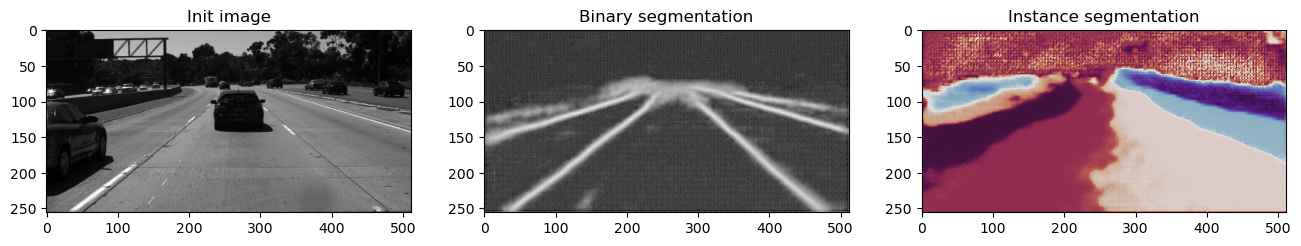

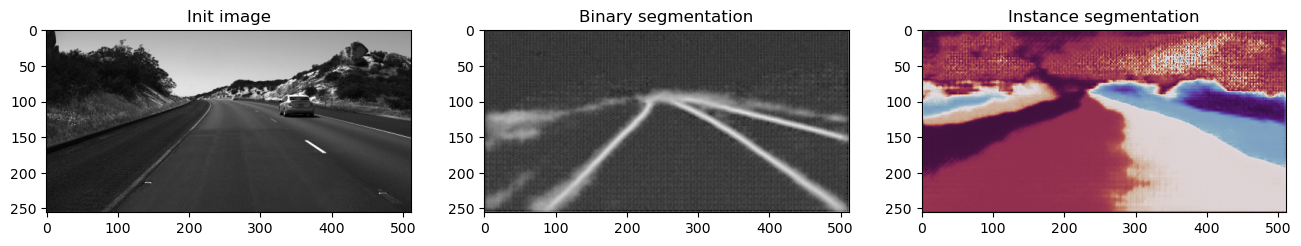

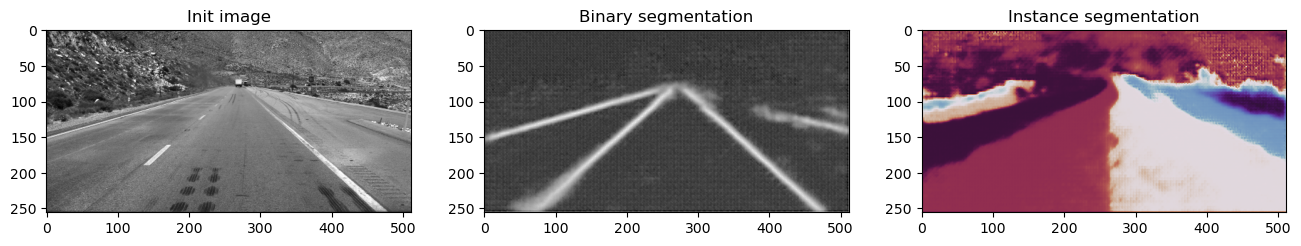

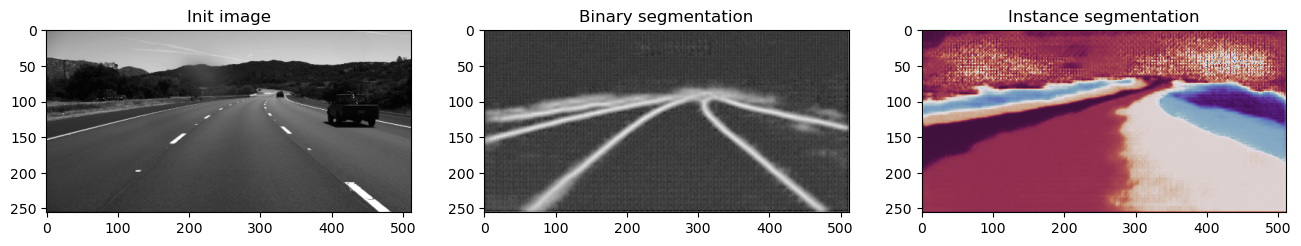

100%|██████████| 90/90 [00:07<00:00, 11.32it/s]

Binary Loss = 0.046, Instance Loss = 0.333, Binary Accuracy = 0.983




(0.04572099, 0.3327858, 0.9827707386549625)

In [11]:
val_dataset_enet = LaneDataset(dataset_path='TUSimple/train_set/', train=False, transform=False)
val_dataloader_enet = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=True)

sf.plot_segmentation(enet_model, val_dataloader_enet, device)
sf.calc_enet_segmentation_scores(enet_model, dataset=val_dataset, device=device)

## Homograpy Prediction Code

In [9]:
from modules.datasets.HomographyDataset import HomographyPredictionDataset

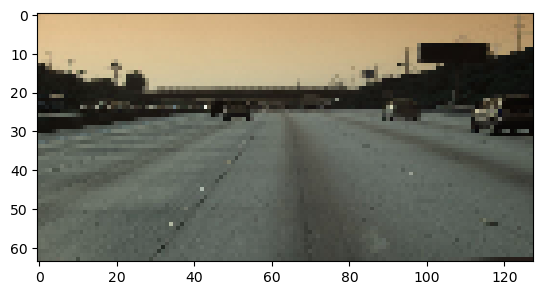

In [10]:
homo = HomographyPredictionDataset('./TUSimple/train_set')

plt.imshow(homo[np.random.randint(1,100)][0].permute(1, 2, 0))
plt.show()

Now we need to implement the H-Net. It should return homography matrix that is parametrized by 6 numbers.
Corresponding section is CURVE FITTING USING H-NET in the[ LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

We suggest to follow the paper and take 64x128 image as in input.

Homography projection contains discontinuities, therefore it could be quite difficult to train the network. In order to simplify the problem we propose not to train the homography from scratch, but train some correction to a good starting point.

In [11]:
from modules.models.HNetModel import HNet

Finally, we need to implement the loss to fit the network. This is the most difficult part of the project. Homography loss should do the following:

1. Project ground truth trajectory to the new plane according to the homography to obtain $(x', y')$.
2. Perform polynomial fitting $x' = f(y')$. Your code should work correctly with 2-nd and 3-rd order polynomials. Polynomial fitting should be done with the closed-form solution: $w = (Y^TY)^{-1}Y^Tx$ to be able to pass a gradient through.
3. Compute back projection with the inverse homography.
4. Compute loss between back projected $\hat{x}$ and ground truth $x$.

The full description can be found in the [LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

**IMPORTANT NOTES**

* To fit the polynomial you need to compute the inverse matrix. Computation of the inverse is computation unstable operation. With the help of the SVD you can compute pseudo-inverse matrix: $(X^TX)^{-1}X^T$. In torch this function is called `torch.pinverse`.
* After projection use of the raw $y'$ can be impractical. The features for the polynomial fitting could have a high correlation and therefore solution can be unstable. At first, you need to map $y'$ to some fixed size segment and only then perform a fit.
* After projection some points can occur on the other side of image (bottom part of the projection in the example above). You may want to exclude them, because otherwise polynomial is not going to have much sense and gradients can have a dramatically large values. Positive $w$ in homogeneous coordinates indicates that point is on the wrong side.
* If use the homography provided above, your ground truth should have the same scale, as an image
* Every division in your network is a potential place to obtain `nan` in gradients. Use the following trick to obtain less divisions:
after computing the projection, remember the $w$. Then, before the back projection, multiply your vector by $w$. After back projection you will see that $w$ is equal to 1. So you don't need to devide your vector by $w$.
* You correction to the initial homography could be very big and can completely spoil the homography. So you may need to scale the output of the last layer in the HNet to obtain a smaller corrections.


In [12]:
from modules.models.HomographyLoss import HomographyLoss

Finally, train the homography net with the 2-nd order polynomial fitting (you can 3-rd order but we found out that it is much easier to train h-net with the 2-nd order polynomials).

We found out that SGD fits much better for this architectures. Adam (and momentums inside) can ruin the weights because of the discontinuities in the target function surface.

Demonstrate the difference in homography loss between h-net and provided fixed homography on the validation samples.

In [19]:
# Train the H-Net || poly 2 by default
BATCH_SIZE = 16
LR = 0.001
NUM_EPOCHS = 50
MOMENTUM = 0.9

homo_data = HomographyPredictionDataset()
homo_dataloader = torch.utils.data.DataLoader(homo_data, batch_size=BATCH_SIZE, shuffle=False)

hnet_model = HNet().to(device)

params = [p for p in hnet_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LR, momentum=MOMENTUM)
criterion = HomographyLoss(device=device)

In [198]:
sf.train_hnet(hnet=hnet_model, 
              dataloader=homo_dataloader,
              crit=criterion, 
              optimizer=optimizer,
              device=device,
              epochs=NUM_EPOCHS)

Epoch 1, loss = 637.1043753077182


Epoch 2, loss = 0.45411285874695995


Epoch 3, loss = 0.4539888603418928


Epoch 4, loss = 0.4538649898195041


Epoch 5, loss = 0.453741214032702


Epoch 6, loss = 0.4536175072993896


Epoch 7, loss = 0.45349388166887267


Epoch 8, loss = 0.45337036030390787


Epoch 9, loss = 0.453246965058901


Epoch 10, loss = 0.453123734369505


Epoch 11, loss = 0.4530006739835718


Epoch 12, loss = 0.45287776583741


Epoch 13, loss = 0.4527549859947934


Epoch 14, loss = 0.45263231934047043


Epoch 15, loss = 0.45250982390413974


Epoch 16, loss = 0.4523875147747507


Epoch 17, loss = 0.45226534642238014


Epoch 18, loss = 0.4521432999060219


Epoch 19, loss = 0.4520213438346289


Epoch 20, loss = 0.4518995125263376


Epoch 21, loss = 0.45177777651575673


Epoch 22, loss = 0.451656127013229


Epoch 23, loss = 0.4515345620189241


Epoch 24, loss = 0.45141307054276425


Epoch 25, loss = 0.4512916789733417


Epoch 26, loss = 0.4511704551639147


Epoch 27, loss = 0.4510494038866789


Epoch 28, loss = 0.4509284753081014


Epoch 29, loss = 0.4508076736416835


Epoch 30, loss = 0.4506869277559907


Epoch 31, loss = 0.45056626203569766


Epoch 32, loss = 0.45044570654634813


Epoch 33, loss = 0.4503252319115013


Epoch 34, loss = 0.45020485622598005


Epoch 35, loss = 0.4500845667040929


Epoch 36, loss = 0.44996441371735685


Epoch 37, loss = 0.44984437590630605


Epoch 38, loss = 0.4497244680970188


Epoch 39, loss = 0.4496047120316141


Epoch 40, loss = 0.44948510720583723


Epoch 41, loss = 0.4493656453856704


Epoch 42, loss = 0.44924632375703605


Epoch 43, loss = 0.44912718184872


Epoch 44, loss = 0.44900820154241444


Epoch 45, loss = 0.4488893746254859


Epoch 46, loss = 0.44877072939047313


Epoch 47, loss = 0.44865220141530743


Epoch 48, loss = 0.4485338450698662


Epoch 49, loss = 0.44841563795349143


Epoch 50, loss = 0.4482975856181917


In [199]:
# torch.save(hnet_model.state_dict(), f'hnet_{NUM_EPOCHS}_epochs_.pth')  # for training/retraining purposes

# Complete Pipeline

Now you need to implement a class that takes image and a set of $y$ coordinates as an input and returns the $x$ coordinate for each lane in this image.

It should contain the following steps:

1. Apply segmentation network to the image
2. Run DBSCAN over the embeddings for those pixels that are lanes.
3. Apply h-net to the image
4. Project pixel coordinates with the predicted homograpgy
5. Fit the 3-rd order polynomial
6. Predict the lane position for each provided $y$ (you should project this first).
7. Compute back projection and return the positions of $x$ for each lane.

Note: if you weren't able to train the H-Net, you can use the fixed homography here.

In [13]:
from modules.LaneDetector import LaneDetector

Below is the full-blown testing of the models. 

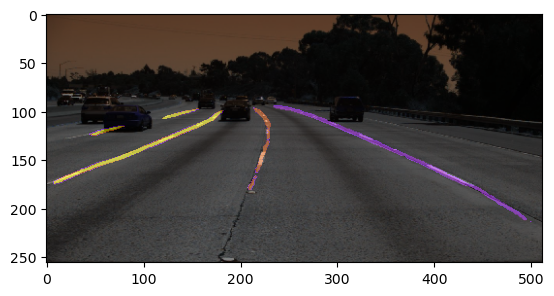

In [45]:
test_img = cv2.imread("./TUSimple/test_set/clips/0601/1495485215551252100/20.jpg")

# load enet
enet_model = ENet(2,5).to(device)
enet_model.load_state_dict(torch.load('trained-models/enet_50_epochs_5d.pth'))

# load hnet
hnet_model = HNet().to(device)
hnet_model.load_state_dict(torch.load('trained-models/hnet_50_epochs.pth'))

# check lanes on test image above
lane_det = LaneDetector(enet=enet_model, hnet=None, with_projection=False, device=device)
lanes = lane_det(test_img)

# plot original image and predicted lanes
plt.imshow(cv2.resize(test_img, (512, 256), interpolation=cv2.INTER_NEAREST_EXACT))
plt.imshow(lanes[0], alpha=.5, cmap='gnuplot')
plt.show()